In [1]:
from dataclasses import dataclass
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf, plot_accf_grid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import acorr_ljungbox


In [2]:
sns.set_theme(style="whitegrid")

ASSIGNMENT_PATH = Path().resolve().parent
DATA_PATH = ASSIGNMENT_PATH / "data"
OUTPUT_PATH = ASSIGNMENT_PATH / "output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
EXPORT_DPI = 600
assert DATA_PATH.exists()

In [3]:
df = pd.read_csv(DATA_PATH / "box_data_60min.csv", parse_dates=["tdate"])

df.head(3)

,thour,tdate,Ph,Tdelta,Gv,Ph.l0,Ph.l1,Ph.l2,Ph.l3,Ph.l4,...,Gv.l1,Gv.l2,Gv.l3,Gv.l4,Gv.l5,Gv.l6,Gv.l7,Gv.l8,Gv.l9,Gv.l10
0,19,2013-01-30 02:00:00,56,13.253583,-0.498643,56,55,57,57,58,...,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339,20.475484
1,20,2013-01-30 03:00:00,54,13.181458,-1.127035,54,56,55,57,57,...,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339
2,21,2013-01-30 04:00:00,55,12.968792,-0.643298,55,54,56,55,57,...,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700


In [4]:
df.dtypes

thour                  int64
tdate         datetime64[ns]
Ph                     int64
Tdelta               float64
Gv                   float64
Ph.l0                  int64
Ph.l1                  int64
Ph.l2                  int64
Ph.l3                  int64
Ph.l4                  int64
Ph.l5                  int64
Ph.l6                  int64
Ph.l7                  int64
Ph.l8                  int64
Ph.l9                  int64
Ph.l10                 int64
Tdelta.l0            float64
Tdelta.l1            float64
Tdelta.l2            float64
Tdelta.l3            float64
Tdelta.l4            float64
Tdelta.l5            float64
Tdelta.l6            float64
Tdelta.l7            float64
Tdelta.l8            float64
Tdelta.l9            float64
Tdelta.l10           float64
Gv.l0                float64
Gv.l1                float64
Gv.l2                float64
Gv.l3                float64
Gv.l4                float64
Gv.l5                float64
Gv.l6                float64
Gv.l7         

## 3.1 Plot

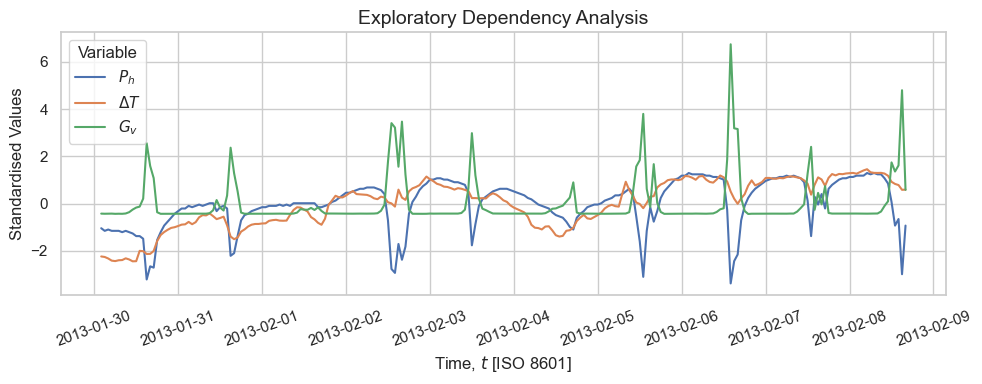

In [5]:
df_standard = df.copy()
COLS_DICT = {
    "Ph": "$P_h$",
    "Tdelta": "$Δ T$",
    "Gv": "$G_v$",
}
COLS = list(COLS_DICT.values())

df_standard = df_standard.rename(columns=COLS_DICT)
df_standard[COLS] = StandardScaler().fit_transform(df_standard[COLS])
dfm_standard = df_standard.melt(id_vars=["tdate"], value_vars=COLS, var_name="Variable")
# fig, ax1 = plt.subplots(figsize=(10, 4))

# # ax2 = ax1.twinx()
fig = plt.figure(figsize=(10, 4))
sns.lineplot(dfm_standard, x="tdate", y="value", hue="Variable")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.ylabel("Standardised Values")
plt.title("Exploratory Dependency Analysis", fontsize=14)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "3_1_analysis.png", dpi=EXPORT_DPI, bbox_inches="tight")
# sns.relplot(dfm, x="tdate", y="value", hue="variable", row="variable", kind="line", height=4, aspect=2, facet_kws={"sharey": False})

## 3.2 - Test/Train Split

In [6]:
train_mask = df["tdate"] <= "2013-02-06 00:00"
df_train = df[train_mask].copy()
df_test = df[~train_mask].copy()

COLS_DICT_VARS = {
    "Ph": "Heater Power, $P_h$ [W]",
    "Tdelta": "Temperature Difference, $Δ T$ [°C]",
    "Gv": "Solar Radiation, $G_v$ [W/m²]",
}
COLS_DICT_VARS_SHORT = {
    "Ph": "$P_h$",
    "Tdelta": "$Δ T$",
    "Gv": "$G_v$",
}
COLS_DICT_VARS_SHORT_UNITS = {
    "Ph": "$P_h$ [W]",
    "Tdelta": "$Δ T$ [°C]",
    "Gv": "$G_v$ [W/m²]",
}

COLS_DICT_ALL = COLS_DICT_VARS | {
    "tdate": "Time, $t$ [ISO 8601]",
}
COLS_VAR_ALL = list(COLS_DICT_ALL.keys())
COLS_FANCY_ALL = list(COLS_DICT_ALL.values())
COLS_VAR_VARS = list(COLS_DICT_VARS.keys())
COLS_FANCY_VARS = list(COLS_DICT_VARS.values())

dfs_train = df_train[COLS_VAR_ALL].copy()

df_train.tail(3)

,thour,tdate,Ph,Tdelta,Gv,Ph.l0,Ph.l1,Ph.l2,Ph.l3,Ph.l4,...,Gv.l1,Gv.l2,Gv.l3,Gv.l4,Gv.l5,Gv.l6,Gv.l7,Gv.l8,Gv.l9,Gv.l10
164,183,2013-02-05 22:00:00,93,24.015708,-0.851001,93,90,87,84,79,...,-1.162048,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829,515.796253,276.212968
165,184,2013-02-05 23:00:00,94,23.916333,-0.597271,94,93,90,87,84,...,-0.851001,-1.162048,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829,515.796253
166,185,2013-02-06 00:00:00,96,24.041167,-0.596964,96,94,93,90,87,...,-0.597271,-0.851001,-1.162048,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829


# 3.3 Relationships

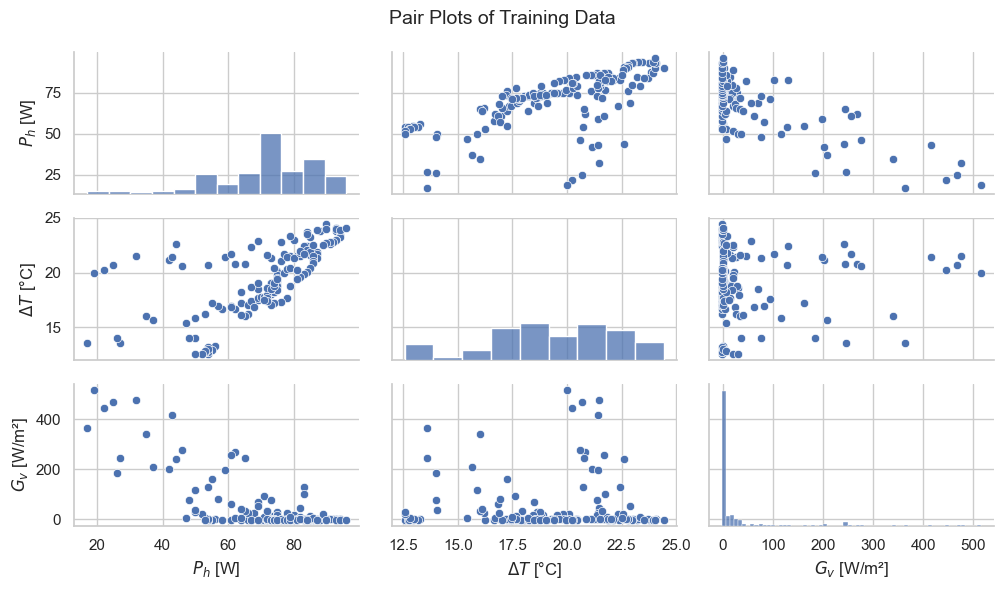

In [7]:
sns.pairplot(dfs_train.rename(columns=COLS_DICT_VARS_SHORT_UNITS), height=2, aspect=1.7)
plt.suptitle("Pair Plots of Training Data", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "3_3_pairplot.png", dpi=EXPORT_DPI, bbox_inches="tight")

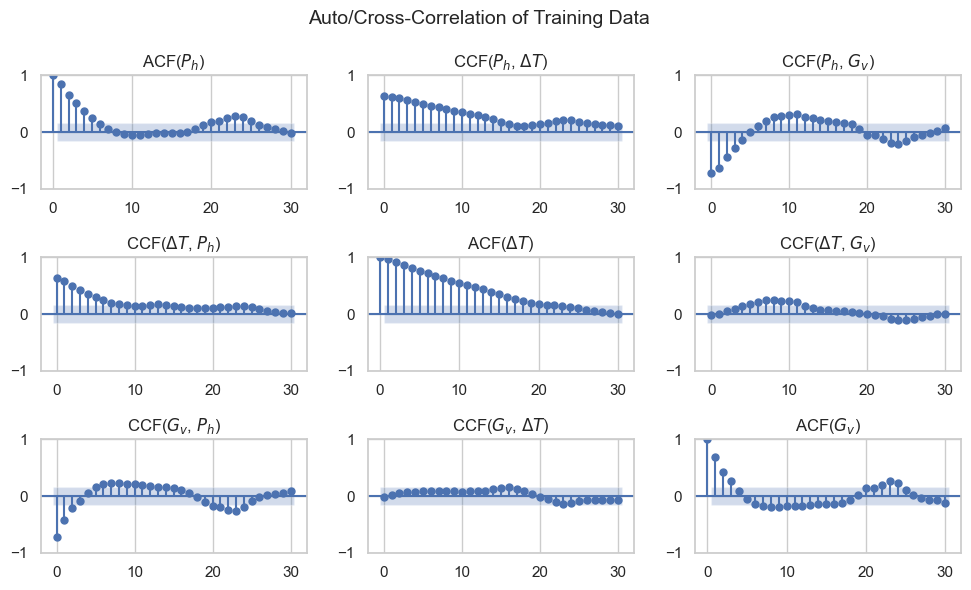

In [8]:
# plot_acf(dfs_train["Tdelta"], lags=24, title="ACF of Temperature Difference", zero=False)
# plot_pacf(dfs_train["Tdelta"], lags=24, title="PACF of Temperature Difference", zero=False)

fig = plt.figure(figsize=(10, 6))
plot_accf_grid(dfs_train[COLS_VAR_VARS].rename(columns=COLS_DICT_VARS_SHORT), lags=30, negative_lags=False, fig=fig)
plt.suptitle("Auto/Cross-Correlation of Training Data", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "3_3_acf_ccf.png", dpi=EXPORT_DPI, bbox_inches="tight")

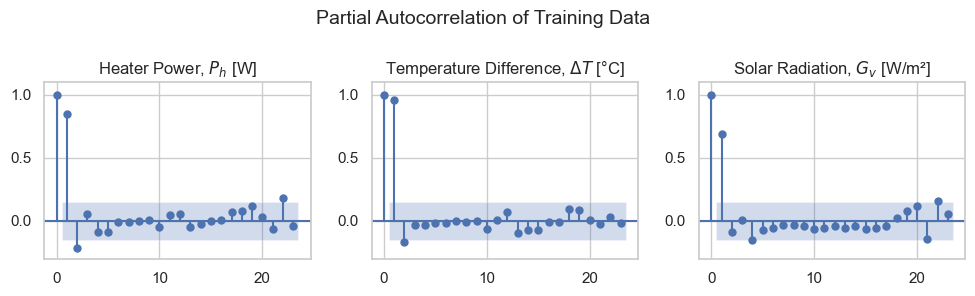

In [9]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
plot_pacf(dfs_train["Ph"], title="Heater Power, $P_h$ [W]", ax=ax1)
ax1.set_ylim(-0.3, 1.1)
plot_pacf(dfs_train["Tdelta"], title="Temperature Difference, $Δ T$ [°C]", ax=ax2)
ax2.set_ylim(-0.3, 1.1)
plot_pacf(dfs_train["Gv"], title="Solar Radiation, $G_v$ [W/m²]", ax=ax3)
ax3.set_ylim(-0.3, 1.1)
plt.suptitle("Partial Autocorrelation of Training Data", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "3_3_pacf.png", dpi=EXPORT_DPI, bbox_inches="tight")


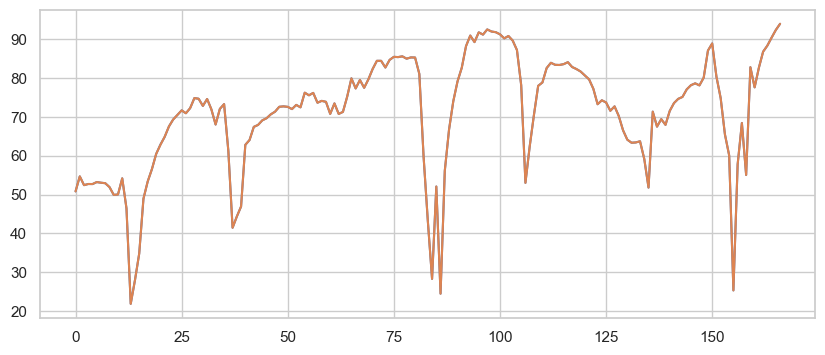

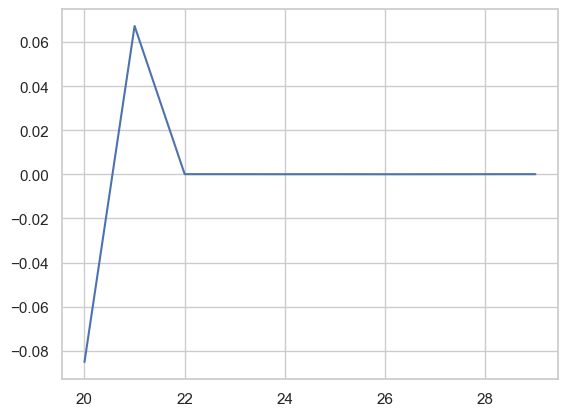

In [10]:
model = SARIMAX(
    endog=df_train["Ph"],
    exog=df_train[["Tdelta", "Gv"]],
    order=(1, 0, 0),
)

result = model.fit()

# result.plot_diagnostics()

params = result.params

Gv = df_train["Gv"].values
Gv_shock = Gv.copy()
k = 20
Gv_shock[k] += 1.0

no_shock_exog = df_train[["Tdelta", "Gv"]].copy()
no_shock_exog["Gv"] = Gv

shock_exog = df_train[["Tdelta", "Gv"]].copy()
shock_exog["Gv"] = Gv_shock

model_no_shock = SARIMAX(
    endog=df_train["Ph"],
    exog=no_shock_exog,
).fit()
model_shock = SARIMAX(
    endog=df_train["Ph"],
    exog=shock_exog,
).fit()

predict_no_shock = model_no_shock.predict(params=params)
predict_shock = model_shock.predict(params=params)

plt.figure(figsize=(10, 4))
plt.plot(predict_no_shock, label="No Shock")
plt.plot(predict_shock, label="Shock")

diff = predict_shock - predict_no_shock
plt.figure()
plt.plot(diff[k:k+10], label="Difference")
# plt.plot(diff, label="Difference")





# model_shock_Gv = SARIMAX(
#     endog=df_train["Ph"],

# )
# out = result.predict()
# plt.plot(out)
# plt.plot(df_train["Ph"])

# model.impulse_responses(params=result.params, steps=10, impulse="Gv")

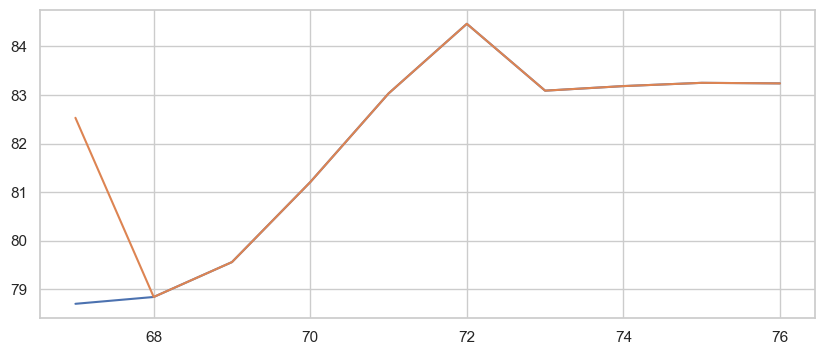

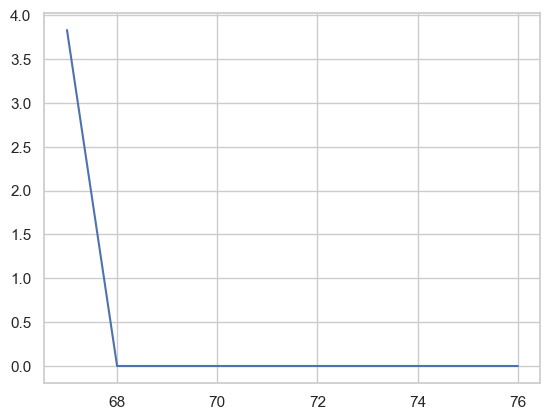

In [11]:
model = SARIMAX(
    endog=df_train["Ph"],
    exog=df_train[["Tdelta", "Gv"]],
    order=(1, 0, 0),
)

result = model.fit()

# result.plot_diagnostics()

params = result.params

Gv = df_train["Tdelta"].values
Gv_shock = Gv.copy()
k = len(Gv) - 100
Gv_shock[k] += 1.0

no_shock_exog = df_train[["Tdelta", "Gv"]].copy()
no_shock_exog["Tdelta"] = Gv

shock_exog = df_train[["Tdelta", "Gv"]].copy()
shock_exog["Tdelta"] = Gv_shock

model_no_shock = SARIMAX(
    endog=df_train["Ph"].iloc[:k],
    exog=no_shock_exog.iloc[:k],
)
result_no_shock = model_no_shock.fit()
result_no_shock.initialize(model_no_shock, params=params)
model_shock = SARIMAX(
    endog=df_train["Ph"].iloc[:k],
    exog=shock_exog.iloc[:k],
)
result_shock = model_shock.fit()
result_shock.initialize(model_shock, params=params)

predict_no_shock = result_no_shock.forecast(steps=10, exog=no_shock_exog.iloc[k:k+10])
predict_shock = result_shock.forecast(steps=10, exog=shock_exog.iloc[k:k+10])

plt.figure(figsize=(10, 4))
plt.plot(predict_no_shock, label="No Shock")
plt.plot(predict_shock, label="Shock")

diff = predict_shock - predict_no_shock
plt.figure()
plt.plot(diff, label="Difference")

## 3.5

,lb_stat,lb_pvalue
1,74.480196,6.124964e-18
2,111.708053,5.532284e-25
3,131.645287,2.390529e-28
4,144.258397,3.457625e-30
5,150.107395,1.266676e-30
...,...,...
90,535.215938,1.747141e-64
91,540.084151,5.607180e-65
92,547.042284,7.511910e-66
93,552.378379,1.982733e-66


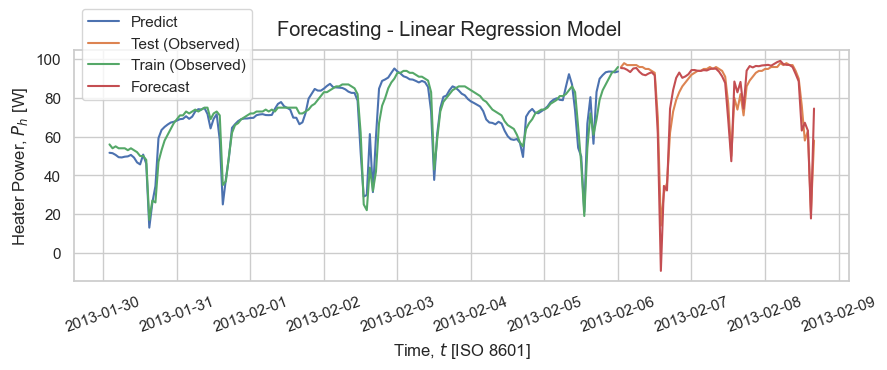

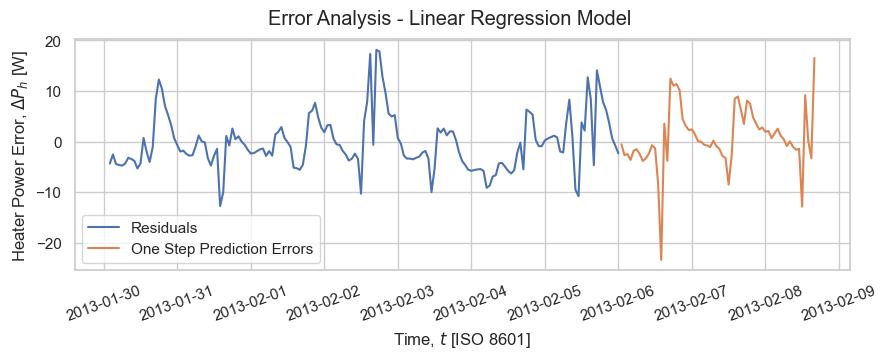

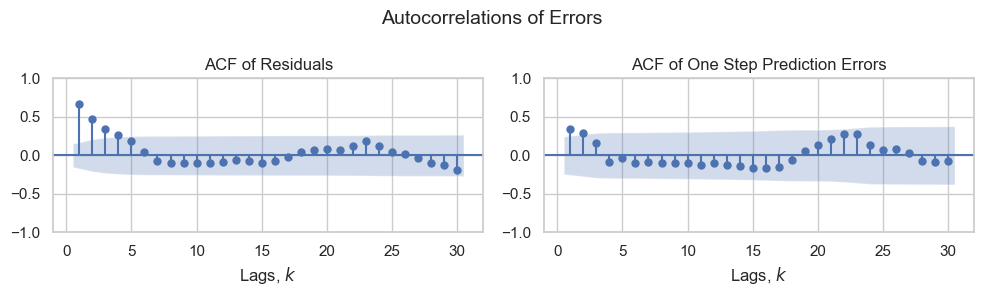

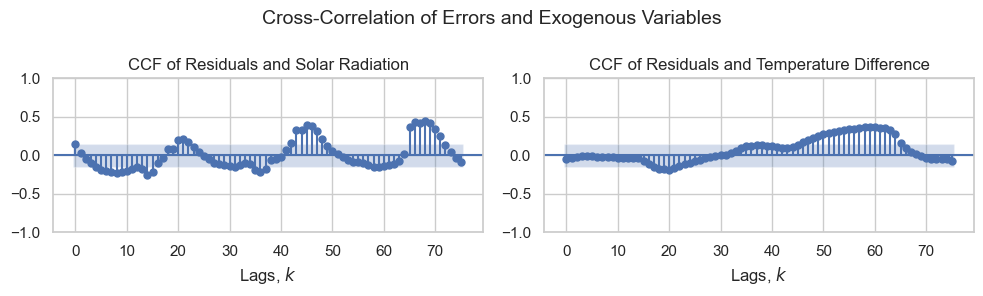

In [ ]:
# We use GLS
from statsmodels.regression.linear_model import GLS

model = GLS(
    endog=df_train["Ph"],
    exog=df_train[["Tdelta", "Gv"]],
)
result = model.fit()

df_results = pd.DataFrame()

dpredict = pd.DataFrame({"Ph": result.fittedvalues, "Type": "Predict"})
dtrain = pd.DataFrame({"Ph": df_train["Ph"], "Type": "Train (Observed)"})
dtest = pd.DataFrame({"Ph": df_test["Ph"], "Type": "Test (Observed)"})
forecast = result.predict(exog=df_test[["Tdelta", "Gv"]])
dforecast = pd.DataFrame({"Ph": result.predict(exog=df_test[["Tdelta", "Gv"]]), "Type": "Forecast"})

df_results = pd.concat([dpredict, dtest, dtrain, dforecast], axis=0)
df_results["tdate"] = df["tdate"].copy()

plt.figure(figsize=(10, 3))
sns.lineplot(df_results, x="tdate", y="Ph", hue="Type")

plt.suptitle("Forecasting - Linear Regression Model")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.xticks(rotation=20)
sns.move_legend(plt.gca(), "lower left", bbox_to_anchor=(0, 0.75), title="")
plt.ylabel("Heater Power, $P_h$ [W]")

plt.savefig(OUTPUT_PATH / "3_5_forecast.png", dpi=EXPORT_DPI, bbox_inches="tight")

## Residuals
# plt.figure(figsize=(10, 3))
df_residuals = pd.DataFrame()
df_residuals["Ph"] = dpredict["Ph"] - dtrain["Ph"]
df_residuals["tdate"] = df_train["tdate"].copy()
df_residuals["Type"] = "Residuals"
# sns.lineplot(df_residuals, x="tdate", y="Ph")

# One step prediction errors
# plt.figure(figsize=(10, 3))
df_onestep = pd.DataFrame()
df_onestep["Ph"] = dforecast["Ph"] - dtest["Ph"]
df_onestep["tdate"] = df_test["tdate"].copy()
df_onestep["Type"] = "One Step Prediction Errors"
# sns.lineplot(df_onestep, x="tdate", y="Ph")

df_resids = pd.concat([df_residuals, df_onestep], axis=0)
plt.figure(figsize=(10, 3))
sns.lineplot(df_resids, x="tdate", y="Ph", hue="Type")

plt.suptitle("Error Analysis - Linear Regression Model")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.xticks(rotation=20)
sns.move_legend(plt.gca(), "lower left", bbox_to_anchor=(0, 0), title="")
plt.ylabel("Heater Power Error, $ΔP_h$ [W]")

plt.savefig(OUTPUT_PATH / "3_5_errors.png", dpi=EXPORT_DPI, bbox_inches="tight")

LAGS_ACF = 30
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df_residuals["Ph"], lags=LAGS_ACF, title="ACF of Residuals", zero=False, ax=ax)
ax.set_xlabel("Lags, $k$")
plt.suptitle("Autocorrelations of Errors", fontsize=14)
plt.tight_layout()

plt.savefig(OUTPUT_PATH / "3_5_acf.png", dpi=EXPORT_DPI, bbox_inches="tight")

LAGS_CCF = 75
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot_ccf(df_residuals["Ph"], df["Gv"], ax=ax1, title="CCF of Residuals and Solar Radiation", lags=LAGS_CCF)
ax1.set_xlabel("Lags, $k$")
plot_ccf(df_residuals["Ph"], df["Tdelta"], ax=ax2, title="CCF of Residuals and Temperature Difference", lags=LAGS_CCF)
ax2.set_xlabel("Lags, $k$")
plt.suptitle("Cross-Correlation of Errors and Exogenous Variables", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / "3_5_ccf.png", dpi=EXPORT_DPI, bbox_inches="tight")


result_3_5 = result

acorr_ljungbox(df_residuals["Ph"], auto_lag=True, return_df=True)

In [13]:
# # 3.6
# # We use AR(1)-X(1, 1)
# # from statsmodels.regression.linear_model import GLS
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model = SARIMAX(
#     order=(1, 0, 0),
#     endog=df_train["Ph"],
#     exog=df_train[["Tdelta", "Gv"]],
# )
# result = model.fit()

# df_results = pd.DataFrame()

# dpredict = pd.DataFrame({"Ph": result.fittedvalues, "Type": "Predict"})
# dtrain = pd.DataFrame({"Ph": df_train["Ph"], "Type": "Train (Observed)"})
# dtest = pd.DataFrame({"Ph": df_test["Ph"], "Type": "Test (Observed)"})
# # forecast = result.forecast(exog=df_test[["Tdelta", "Gv"]])
# start = len(df_train)
# end = len(df_train) + len(df_test) - 1
# forecast = result.predict(start=start, end=end, exog=df_test[["Tdelta", "Gv"]])
# dforecast = pd.DataFrame({"Ph": forecast, "Type": "Forecast"})

# # dforecast = pd.DataFrame({"Ph": []})
# df_results = pd.concat([dpredict, dtest, dtrain, dforecast], axis=0)
# df_results["tdate"] = df["tdate"].copy()

# plt.figure(figsize=(10, 3))
# sns.lineplot(df_results, x="tdate", y="Ph", hue="Type")

# plt.suptitle("Forecasting - AR(1)-X(1,1) Model")
# plt.xlabel("Time, $t$ [ISO 8601]")
# plt.xticks(rotation=20)
# sns.move_legend(plt.gca(), "lower left", bbox_to_anchor=(0, 0.75), title="")
# plt.ylabel("Heater Power, $P_h$ [W]")

# plt.savefig(OUTPUT_PATH / "3_5_forecast.png", dpi=EXPORT_DPI)

# ## Residuals
# plt.figure(figsize=(10, 3))
# df_residuals = pd.DataFrame()
# df_residuals["Ph"] = dpredict["Ph"] - dtrain["Ph"]
# df_residuals["tdate"] = df_train["tdate"].copy()
# sns.lineplot(df_residuals, x="tdate", y="Ph")

# # One step prediction errors
# plt.figure(figsize=(10, 3))
# df_onestep = pd.DataFrame()
# df_onestep["Ph"] = dforecast["Ph"] - dtest["Ph"]
# df_onestep["tdate"] = df_test["tdate"].copy()
# sns.lineplot(df_onestep, x="tdate", y="Ph")

# # plt.tight_layout()
# # result.fittedvalues
# # df_test
# # result./
# # plt.plot(result.fittedvalues)
# # plt.plot(df_train["Ph"])
# # plt.plot(df_test["Ph"])
# # plt.plot(result.predict(exog=df_test[["Tdelta", "Gv"]]))



,lb_stat,lb_pvalue
1,0.411932,0.520991


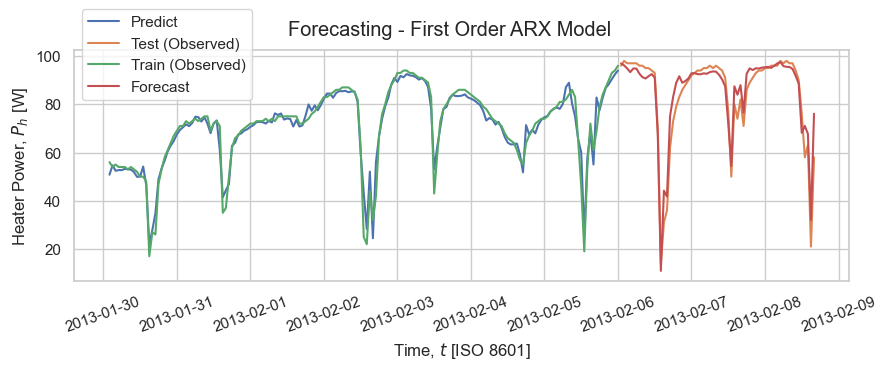

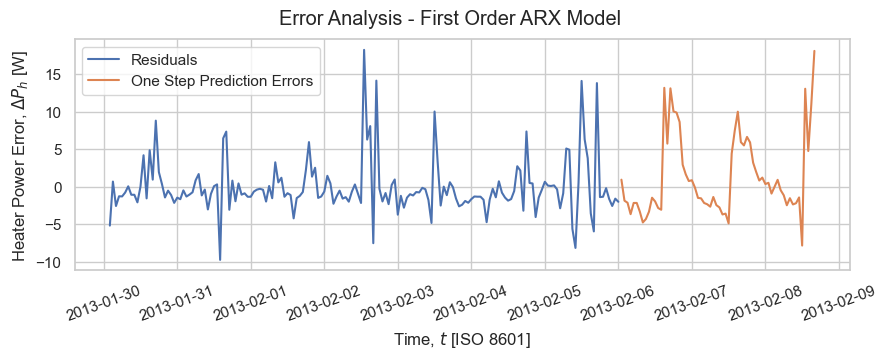

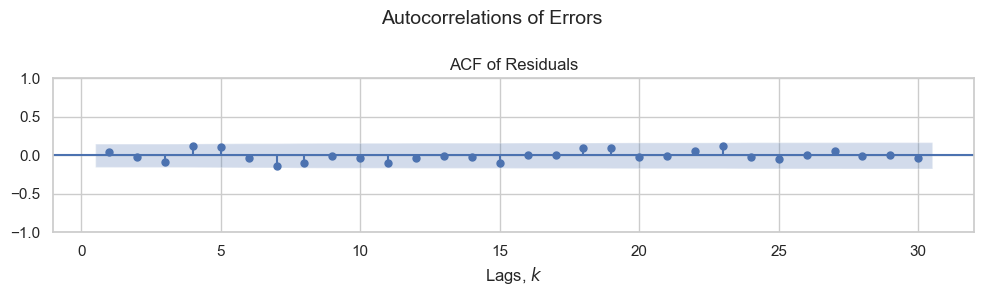

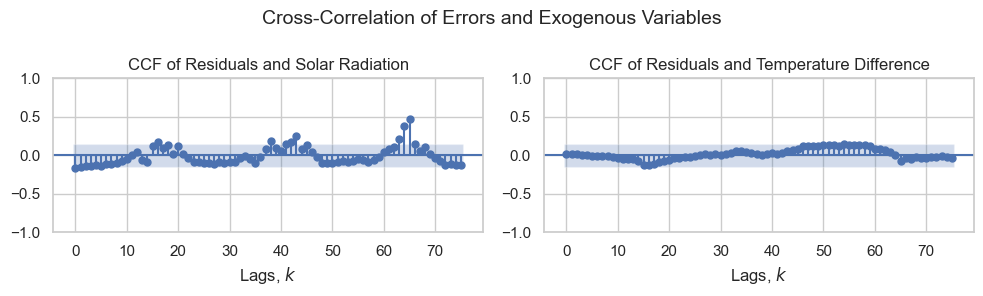

In [14]:
# We use GLS
ID = "3_6"
MODEL = "First Order ARX Model"

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    order=(1, 0, 0),
    endog=df_train["Ph"],
    exog=df_train[["Tdelta", "Gv"]],
)
result = model.fit()

df_results = pd.DataFrame()

dpredict = pd.DataFrame({"Ph": result.fittedvalues, "Type": "Predict"})
dtrain = pd.DataFrame({"Ph": df_train["Ph"], "Type": "Train (Observed)"})
dtest = pd.DataFrame({"Ph": df_test["Ph"], "Type": "Test (Observed)"})
start = len(df_train)
end = len(df_train) + len(df_test) - 1
forecast = result.predict(start=start, end=end, exog=df_test[["Tdelta", "Gv"]])
dforecast = pd.DataFrame({"Ph": forecast, "Type": "Forecast"})

df_results = pd.concat([dpredict, dtest, dtrain, dforecast], axis=0)
df_results["tdate"] = df["tdate"].copy()

plt.figure(figsize=(10, 3))
sns.lineplot(df_results, x="tdate", y="Ph", hue="Type")

plt.suptitle(f"Forecasting - {MODEL}")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.xticks(rotation=20)
sns.move_legend(plt.gca(), "lower left", bbox_to_anchor=(0, 0.75), title="")
plt.ylabel("Heater Power, $P_h$ [W]")

plt.savefig(OUTPUT_PATH / f"{ID}_forecast.png", dpi=EXPORT_DPI, bbox_inches="tight")

## Residuals
# plt.figure(figsize=(10, 3))
df_residuals = pd.DataFrame()
df_residuals["Ph"] = dpredict["Ph"] - dtrain["Ph"]
df_residuals["tdate"] = df_train["tdate"].copy()
df_residuals["Type"] = "Residuals"
# sns.lineplot(df_residuals, x="tdate", y="Ph")

# One step prediction errors
# plt.figure(figsize=(10, 3))
df_onestep = pd.DataFrame()
df_onestep["Ph"] = dforecast["Ph"] - dtest["Ph"]
df_onestep["tdate"] = df_test["tdate"].copy()
df_onestep["Type"] = "One Step Prediction Errors"
# sns.lineplot(df_onestep, x="tdate", y="Ph")

df_resids = pd.concat([df_residuals, df_onestep], axis=0)
plt.figure(figsize=(10, 3))
sns.lineplot(df_resids, x="tdate", y="Ph", hue="Type")

plt.suptitle(f"Error Analysis - {MODEL}")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.xticks(rotation=20)
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(0, 1), title="")
plt.ylabel("Heater Power Error, $ΔP_h$ [W]")

plt.savefig(OUTPUT_PATH / f"{ID}_errors.png", dpi=EXPORT_DPI, bbox_inches="tight")

LAGS_ACF = 30
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df_residuals["Ph"], lags=LAGS_ACF, title="ACF of Residuals", zero=False, ax=ax)
ax.set_xlabel("Lags, $k$")
plt.suptitle("Autocorrelations of Errors", fontsize=14)
plt.tight_layout()

plt.savefig(OUTPUT_PATH / f"{ID}_acf.png", dpi=EXPORT_DPI, bbox_inches="tight")

LAGS_CCF = 75
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot_ccf(df_residuals["Ph"], df["Gv"], ax=ax1, title="CCF of Residuals and Solar Radiation", lags=LAGS_CCF)
ax1.set_xlabel("Lags, $k$")
plot_ccf(df_residuals["Ph"], df["Tdelta"], ax=ax2, title="CCF of Residuals and Temperature Difference", lags=LAGS_CCF)
ax2.set_xlabel("Lags, $k$")
plt.suptitle("Cross-Correlation of Errors and Exogenous Variables", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / f"{ID}_ccf.png", dpi=EXPORT_DPI, bbox_inches="tight")


result_3_6 = result

acorr_ljungbox(df_residuals["Ph"], auto_lag=True, return_df=True)

c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignments\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,lb_stat,lb_pvalue
1,0.481478,0.487754


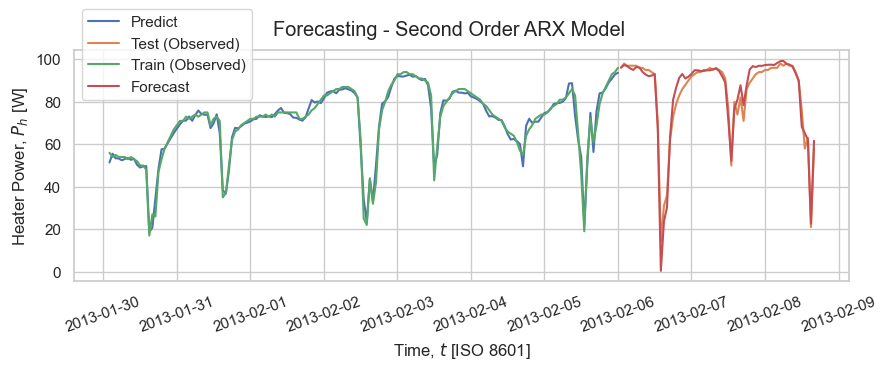

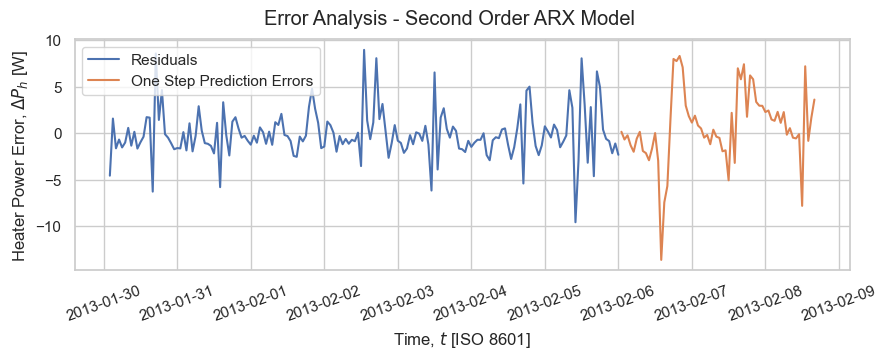

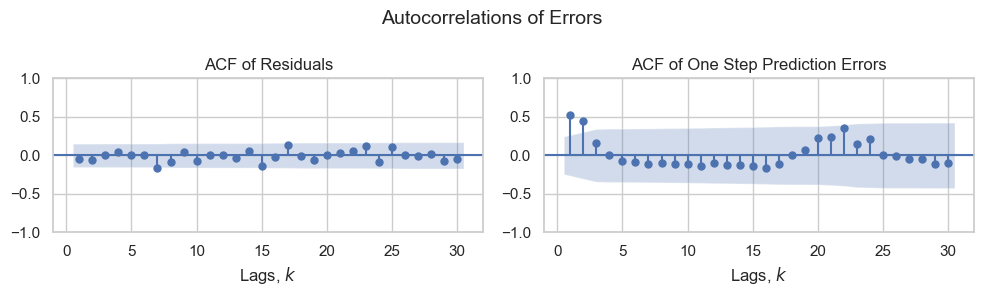

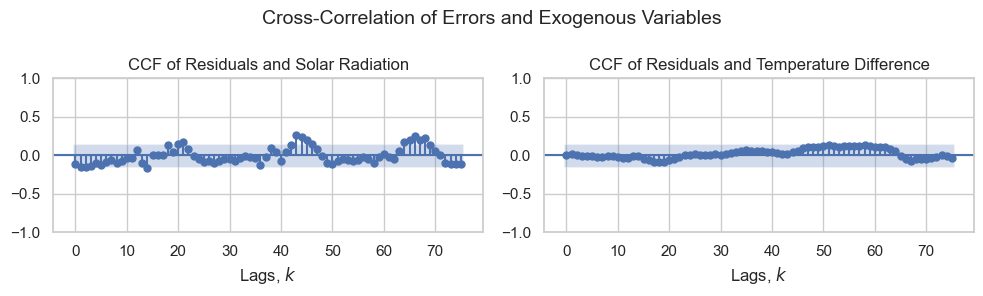

In [ ]:
ID = "3_7"
MODEL = "Second Order ARX Model"

from statsmodels.tsa.statespace.sarimax import SARIMAX

EXOGS = ["Tdelta.l0", "Tdelta.l1", "Gv.l0", "Gv.l1"]
model = SARIMAX(
    order=(2, 0, 0),
    endog=df_train["Ph"],
    exog=df_train[EXOGS],
)
result = model.fit()

df_results = pd.DataFrame()

dpredict = pd.DataFrame({"Ph": result.fittedvalues, "Type": "Predict"})
dtrain = pd.DataFrame({"Ph": df_train["Ph"], "Type": "Train (Observed)"})
dtest = pd.DataFrame({"Ph": df_test["Ph"], "Type": "Test (Observed)"})
start = len(df_train)
end = len(df_train) + len(df_test) - 1
forecast = result.predict(start=start, end=end, exog=df_test[EXOGS])
dforecast = pd.DataFrame({"Ph": forecast, "Type": "Forecast"})

df_results = pd.concat([dpredict, dtest, dtrain, dforecast], axis=0)
df_results["tdate"] = df["tdate"].copy()

plt.figure(figsize=(10, 3))
sns.lineplot(df_results, x="tdate", y="Ph", hue="Type")

plt.suptitle(f"Forecasting - {MODEL}")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.xticks(rotation=20)
sns.move_legend(plt.gca(), "lower left", bbox_to_anchor=(0, 0.75), title="")
plt.ylabel("Heater Power, $P_h$ [W]")

plt.savefig(OUTPUT_PATH / f"{ID}_forecast.png", dpi=EXPORT_DPI, bbox_inches="tight")

## Residuals
# plt.figure(figsize=(10, 3))
df_residuals = pd.DataFrame()
df_residuals["Ph"] = dpredict["Ph"] - dtrain["Ph"]
df_residuals["tdate"] = df_train["tdate"].copy()
df_residuals["Type"] = "Residuals"
# sns.lineplot(df_residuals, x="tdate", y="Ph")

# One step prediction errors
# plt.figure(figsize=(10, 3))
df_onestep = pd.DataFrame()
df_onestep["Ph"] = dforecast["Ph"] - dtest["Ph"]
df_onestep["tdate"] = df_test["tdate"].copy()
df_onestep["Type"] = "One Step Prediction Errors"
# sns.lineplot(df_onestep, x="tdate", y="Ph")

df_resids = pd.concat([df_residuals, df_onestep], axis=0)
plt.figure(figsize=(10, 3))
sns.lineplot(df_resids, x="tdate", y="Ph", hue="Type")

plt.suptitle(f"Error Analysis - {MODEL}")
plt.xlabel("Time, $t$ [ISO 8601]")
plt.xticks(rotation=20)
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(0, 1), title="")
plt.ylabel("Heater Power Error, $ΔP_h$ [W]")

plt.savefig(OUTPUT_PATH / f"{ID}_errors.png", dpi=EXPORT_DPI, bbox_inches="tight")

LAGS_ACF = 30
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(df_residuals["Ph"], lags=LAGS_ACF, title="ACF of Residuals", zero=False, ax=ax)
ax.set_xlabel("Lags, $k$")
plt.suptitle("Autocorrelations of Errors", fontsize=14)
plt.tight_layout()

plt.savefig(OUTPUT_PATH / f"{ID}_acf.png", dpi=EXPORT_DPI, bbox_inches="tight")

LAGS_CCF = 75
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
plot_ccf(df_residuals["Ph"], df["Gv"], ax=ax1, title="CCF of Residuals and Solar Radiation", lags=LAGS_CCF)
ax1.set_xlabel("Lags, $k$")
plot_ccf(df_residuals["Ph"], df["Tdelta"], ax=ax2, title="CCF of Residuals and Temperature Difference", lags=LAGS_CCF)
ax2.set_xlabel("Lags, $k$")
plt.suptitle("Cross-Correlation of Errors and Exogenous Variables", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / f"{ID}_ccf.png", dpi=EXPORT_DPI, bbox_inches="tight")

result_3_7 = result


acorr_ljungbox(df_residuals["Ph"], auto_lag=True, return_df=True)

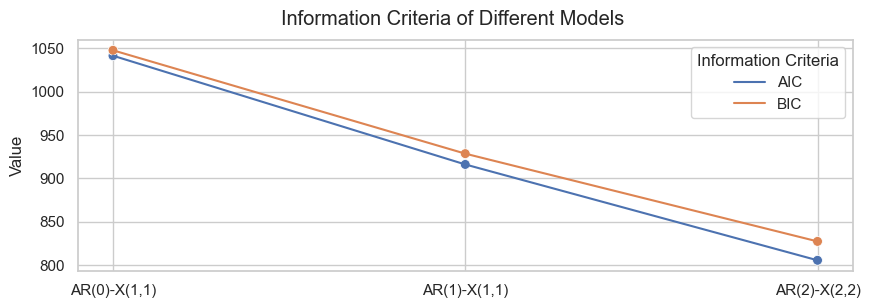

In [16]:
datas = []
for result, model in zip([result_3_5, result_3_6, result_3_7], ["AR(0)-X(1,1)", "AR(1)-X(1,1)", "AR(2)-X(2,2)"]):
    datas.append({
        "value": result.aic,
        "Information Criteria": "AIC",
        "model": model,
    })
    datas.append({
        "value": result.bic,
        "Information Criteria": "BIC",
        "model": model,
    })

df_ic = pd.DataFrame(datas)

plt.figure(figsize=(10, 3))
sns.lineplot(df_ic, x="model", y="value", hue="Information Criteria")
sns.scatterplot(df_ic, x="model", y="value", hue="Information Criteria", legend=False, s=50)
plt.xlabel("")
plt.ylabel("Value")
plt.suptitle("Information Criteria of Different Models")
plt.savefig(OUTPUT_PATH / "3_7_ic.png", dpi=EXPORT_DPI, bbox_inches="tight")

In [17]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
forecast = result.predict(start=start, end=end, exog=df_test[["Tdelta", "Gv"]])

ValueError: Provided exogenous values are not of the appropriate shape. Required (64, 4), got (64, 2).

In [ ]:
df_train

,thour,tdate,Ph,Tdelta,Gv,Ph.l0,Ph.l1,Ph.l2,Ph.l3,Ph.l4,Ph.l5,Ph.l6,Ph.l7,Ph.l8,Ph.l9,Ph.l10,Tdelta.l0,Tdelta.l1,Tdelta.l2,Tdelta.l3,Tdelta.l4,Tdelta.l5,Tdelta.l6,Tdelta.l7,Tdelta.l8,Tdelta.l9,Tdelta.l10,Gv.l0,Gv.l1,Gv.l2,Gv.l3,Gv.l4,Gv.l5,Gv.l6,Gv.l7,Gv.l8,Gv.l9,Gv.l10
0,19,2013-01-30 02:00:00,56,13.253583,-0.498643,56,55,57,57,58,59,59,59,59,59,58,13.253583,13.101333,12.710000,12.839417,13.526042,13.860083,14.189000,13.954708,14.300917,14.376833,14.003250,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339,20.475484
1,20,2013-01-30 03:00:00,54,13.181458,-1.127035,54,56,55,57,57,58,59,59,59,59,59,13.181458,13.253583,13.101333,12.710000,12.839417,13.526042,13.860083,14.189000,13.954708,14.300917,14.376833,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700,8.262339
2,21,2013-01-30 04:00:00,55,12.968792,-0.643298,55,54,56,55,57,57,58,59,59,59,59,12.968792,13.181458,13.253583,13.101333,12.710000,12.839417,13.526042,13.860083,14.189000,13.954708,14.300917,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776,-0.142700
3,22,2013-01-30 05:00:00,54,12.667750,-0.456008,54,55,54,56,55,57,57,58,59,59,59,12.667750,12.968792,13.181458,13.253583,13.101333,12.710000,12.839417,13.526042,13.860083,14.189000,13.954708,-0.456008,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267,-0.451776
4,23,2013-01-30 06:00:00,54,12.605250,-1.534060,54,54,55,54,56,55,57,57,58,59,59,12.605250,12.667750,12.968792,13.181458,13.253583,13.101333,12.710000,12.839417,13.526042,13.860083,14.189000,-1.534060,-0.456008,-0.643298,-1.127035,-0.498643,-0.499338,-0.417959,-0.221011,-0.453375,-0.747238,-0.669267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,181,2013-02-05 20:00:00,87,23.913583,-1.397416,87,84,79,69,61,72,54,19,46,65,83,23.913583,23.524375,23.316458,22.898750,21.679125,21.612125,20.727667,20.000542,20.581917,20.796667,21.749583,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829,515.796253,276.212968,243.440149,102.009803
163,182,2013-02-05 21:00:00,90,24.012958,-1.162048,90,87,84,79,69,61,72,54,19,46,65,24.012958,23.913583,23.524375,23.316458,22.898750,21.679125,21.612125,20.727667,20.000542,20.581917,20.796667,-1.162048,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829,515.796253,276.212968,243.440149
164,183,2013-02-05 22:00:00,93,24.015708,-0.851001,93,90,87,84,79,69,61,72,54,19,46,24.015708,24.012958,23.913583,23.524375,23.316458,22.898750,21.679125,21.612125,20.727667,20.000542,20.581917,-0.851001,-1.162048,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829,515.796253,276.212968
165,184,2013-02-05 23:00:00,94,23.916333,-0.597271,94,93,90,87,84,79,69,61,72,54,19,23.916333,24.015708,24.012958,23.913583,23.524375,23.316458,22.898750,21.679125,21.612125,20.727667,20.000542,-0.597271,-0.851001,-1.162048,-1.397416,-1.602164,7.975355,55.364955,255.584706,34.136063,127.492829,515.796253
